# Install and load libraries

In [ ]:
# Download tensorflow datasets
!pip install tensorflow_datasets

# A dependency of the preprocessing for BERT inputs
!pip install tensorflow_text
!pip install tensorflow_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 80.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 94.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 34.3 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard
    Fou

In [ ]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_text as text

# Load the dataset and model


In [ ]:
# Load and split the data into training, validation and test data
train_dataset, val_dataset, test_dataset = tfds.load(name="imdb_reviews", split=('train[:80%]', 'train[80%:]', 'test'), as_supervised=True)

print("Training set: ", len(train_dataset), "samples")
print("Validation set: ", len(val_dataset), "samples")
print("Test set: ", len(test_dataset), "samples")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteKGVF7P/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteKGVF7P/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteKGVF7P/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
Training set:  20000 samples
Validation set:  5000 samples
Test set:  25000 samples


In [ ]:
### Convert Tensorflow Dataset to numpy arrays of feature vector X and label y

# Convert training set
train_ds_numpy = tfds.as_numpy(train_dataset) # Convert TF Dataset to an iterable of numpy array
train_numpy = np.vstack(list(train_ds_numpy)) # Stack to full numpy array
X_train = np.array(list(map(lambda x: x[0], train_numpy))) # Extract review (index 0) from numpy vector
y_train = np.array(list(map(lambda x: x[1], train_numpy))).astype(np.int16) # Extract label (index 1) from numpy vector and convert grom string to number
print("X_train shape: " + str(X_train.shape))
print("y_train shape: " + str(y_train.shape))

# Convert validation set
val_ds_numpy = tfds.as_numpy(val_dataset) # Convert TF Dataset to an iterable of numpy array
val_numpy = np.vstack(list(val_ds_numpy)) # Stack to full numpy array
X_val = np.array(list(map(lambda x: x[0], val_numpy))) # Extract review (index 0) from numpy vector
y_val = np.array(list(map(lambda x: x[1], val_numpy))).astype(np.int16) # Extract label (index 1) from numpy vector
print("X_val shape: " + str(X_val.shape))
print("y_val shape: " + str(y_val.shape))

# Convert test set
test_ds_numpy = tfds.as_numpy(test_dataset) # Convert TF Dataset to an iterable of numpy array
test_numpy = np.vstack(list(test_ds_numpy)) # Stack to full numpy array
X_test = np.array(list(map(lambda x: x[0], test_numpy))) # Extract review (index 0) from numpy vector
y_test = np.array(list(map(lambda x: x[1], test_numpy))).astype(np.int16) # Extract label (index 1) from numpy vector
print("X_test shape: " + str(X_test.shape))
print("y_test shape: " + str(y_test.shape))

X_train shape: (20000,)
y_train shape: (20000,)
X_val shape: (5000,)
y_val shape: (5000,)
X_test shape: (25000,)
y_test shape: (25000,)


In [ ]:
### Below are two examples of BERT models with corresponding preprocessings for use with them
# Full list of BERT models supported by Tensorflow can be found at https://tfhub.dev/google/collections/bert/1

# Mapping from name to URL of Bert models
map_name_to_model = {
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
}

# Mapping from name to URL of respective processings for the Bert models
map_name_to_preprocess = {
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

### Choose a model: Small BERT model for English language with L-4_H-128_A-2. This means the BERT model has:
# - 4 layers, i.e., 4 Transformer-encoder blocks.
# - Hidden states = 128.
# - Attention heads = 2.
# This Small BERT model is available at https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
bert_name = 'small_bert/bert_en_uncased_L-4_H-128_A-2'

# Get URLs of model and processing from tfhub
tfhub_model = map_name_to_model[bert_name]
tfhub_preprocess = map_name_to_preprocess[bert_name]

print('BERT model selected           : ' + str(tfhub_model))
print('Preprocess model auto-selected: ' + str(tfhub_preprocess))

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
bert_preprocess = hub.KerasLayer(tfhub_preprocess)

In [ ]:
bert_model = hub.KerasLayer(tfhub_model)

# Build and Train the Model

In [ ]:
def build_model():
    text_input = keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_model, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)

    # Extract and combine output embeddings of all
    all_layer_embeddings = outputs['encoder_outputs']
    combined_embedding = tf.concat(all_layer_embeddings, axis=-1)

    # Add global average pooling layer to resize combined_embeddings
    pooled_embedding = keras.layers.GlobalAveragePooling1D()(combined_embedding)

    # Use dense layers to classify
    net = keras.layers.Dense(64, activation='relu')(pooled_embedding)
    net = keras.layers.BatchNormalization()(net)
    net = keras.layers.Dropout(0.5)(net)
    net = keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
    return keras.Model(inputs=text_input, outputs=net, name="BERT_complete_model")

# Build the complete model
model = build_model()

# Print the model architecture
model.summary()

Model: "BERT_complete_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_mask': (None, 128)   0         ['text[0][0]']                
                             , 'input_type_ids': (None,                                           
                              128),                                                               
                              'input_word_ids': (None,                                            
                             128)}                                                                
                                                                                

In [ ]:
#Use learning rate scheduling to gradually adjust the learning rate
initial_learning_rate = 0.1
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=1000,
    end_learning_rate=0.0,
    power=1.0,
    cycle=False
)


# Compile the model
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train,
                    epochs=5,
                    batch_size=64,
                    validation_data=(X_val, y_val))

Epoch 1/5
313/313 [==============================] - 115s 326ms/step - loss: 0.5151 - accuracy: 0.7434 - val_loss: 0.6823 - val_accuracy: 0.6592
Epoch 2/5
313/313 [==============================] - 92s 295ms/step - loss: 0.4255 - accuracy: 0.8084 - val_loss: 0.7888 - val_accuracy: 0.6858
Epoch 3/5
313/313 [==============================] - 91s 290ms/step - loss: 0.3914 - accuracy: 0.8255 - val_loss: 0.4051 - val_accuracy: 0.8128
Epoch 4/5
313/313 [==============================] - 97s 309ms/step - loss: 0.3732 - accuracy: 0.8354 - val_loss: 0.4031 - val_accuracy: 0.8148
Epoch 5/5
313/313 [==============================] - 89s 284ms/step - loss: 0.3683 - accuracy: 0.8392 - val_loss: 0.4030 - val_accuracy: 0.8146


# Plot model training performance

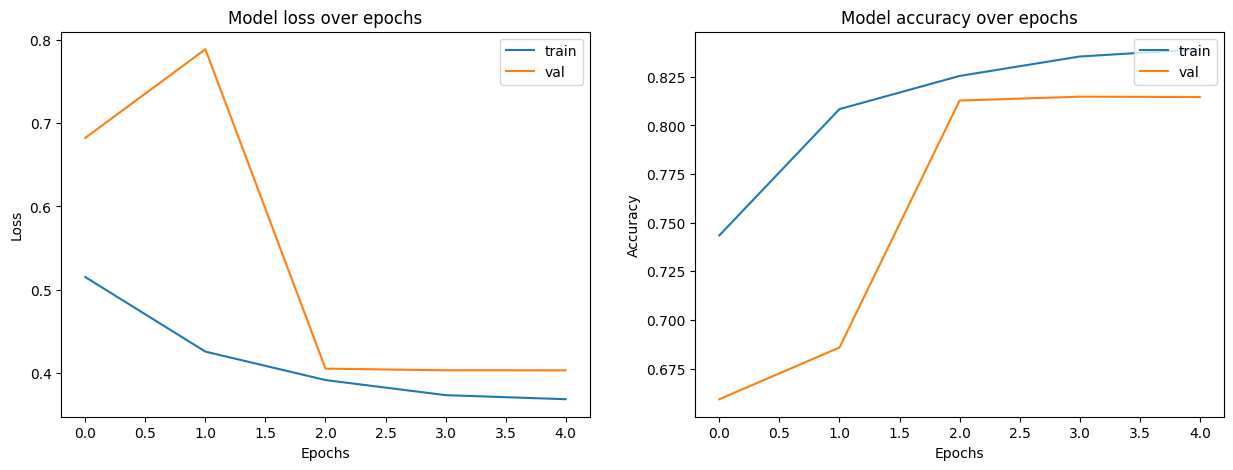

In [ ]:
# Initialize the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot model loss during training
ax1.plot(history.history["loss"])
ax1.plot(history.history["val_loss"])
ax1.legend(["train", "val"], loc="upper right")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Model loss over epochs")

# Plot model accuracy during training
ax2.plot(history.history["accuracy"])
ax2.plot(history.history["val_accuracy"])
ax2.legend(["train", "val"], loc="upper right")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("Model accuracy over epochs")
plt.show()

# Evaulate Model Performance

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

782/782 [==============================] - 58s 74ms/step - loss: 0.4131 - accuracy: 0.8110
Test Loss: 0.4130893647670746
Test Accuracy: 0.8110399842262268


# Predict some samples

In [ ]:
# Make prediction on new text reviews
sample_reviews = [('Kinda mid, fr fr'),
                  ('This monstrocity is a disgrace to cinema, I want to bleach my eyes after watching it.')]
predictions = model.predict(np.array(sample_reviews))
print(predictions[0])
print(predictions[1])

1/1 [==============================] - 0s 27ms/step
[0.63321966]
[0.30678356]
